# Neural Network for ECG Classification



single lead ecg ml 


#### IMPORTS

In [1]:
import torch
import numpy as np

from dataloader import MyCustomDataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim

import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
default_dir = os.getcwd()
def default_directory():
    os.chdir(f"{default_dir}")
    print(f"you are back to the default directory: {default_dir}")


In [3]:
default_directory()
os.getcwd()

you are back to the default directory: /home/karansingh/Documents/summer term/ECG_ML/MAIN


'/home/karansingh/Documents/summer term/ECG_ML/MAIN'

In [4]:
os.chdir("data_prep")
os.getcwd()

'/home/karansingh/Documents/summer term/ECG_ML/MAIN/data_prep'

In [5]:
# get list of all files in the directory
files = os.listdir()
print(files)

['unq_disease_SB.npy', 'data_prep.ipynb', 'data_prep_for_only_one_disease.ipynb', 'README copy', 'unq_disease_ST.npy', 'disease_ST.npy', 'disease_SR.npy', 'README', 'main_1_nn_cg16_leg_singlelead', 'disease_SB.npy', 'unq_disease_SR.npy']


#### LOAD DATA

In [6]:
data_ST_list = np.load("unq_disease_ST.npy")
data_SB_list = np.load("unq_disease_SB.npy")
data_SR_list = np.load("unq_disease_SR.npy")
#print shape of all loaded files
print("shape of ST data: ", data_ST_list.shape)
print("shape of SB data: ", data_SB_list.shape)
print("shape of SR data: ", data_SR_list.shape)



shape of ST data:  (3000, 5000, 12)
shape of SB data:  (5000, 5000, 12)
shape of SR data:  (5000, 5000, 12)


### for lead 1


In [7]:
## Create fake dataset for demonstration purposes

## Load your dataset and use 
# lead 1
images = data_ST_list[:,:,0]

labels=np.zeros(3000)

#SB
images = np.concatenate((images,data_SB_list[:,:,0]))
labels=np.concatenate((labels,np.ones(5000)))

#SR
images = np.concatenate((images,data_SR_list[:,:,0]))
labels=np.concatenate((labels,2*np.ones(5000)))

print("we have ", images.shape[0], " images and ", labels.shape[0], " labels")
                    

we have  13000  images and  13000  labels


In [8]:
len(images),len(labels)

(13000, 13000)

#### CREATE BATCHES

In [9]:
# Create an instance of your dataset
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)
train_dataset = MyCustomDataset(images_train, labels_train)
test_dataset = MyCustomDataset(images_test, labels_test)
# Define a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## model


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    """Base model with 5 layers and dropout"""
    def __init__(self, in_features=5000, h1=1000, h2=250,
                 h3=100, h4=30, h5=10,
                 out_features=3, dropout_p=0.3):
        """Initialize an instance of the model"""
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, h4)
        self.fc5 = nn.Linear(h4, h5)
        self.out = nn.Linear(h5, out_features)
        self.dropout = nn.Dropout(p=dropout_p)  # Dropout layer

    def forward(self, x):
        """Forward method for the layers in the model"""
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.out(x)
        return x


#### TRAINING PARAMETERS

In [11]:
torch.manual_seed(37)  # Set seed for reproducibility
model = Model()

criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
def accuracy(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


#### TRAINING

In [12]:
import torch.nn.functional as F
torch.manual_seed(21)  # Set seed for reproducibility
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model().to(device)

criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

num_epochs = 30
test_losses_list = []
train_losses_list = []
accuracy_train_list = []
accuracy_test_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss, accuracy_train = 0.0, 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        accuracy_train += accuracy(labels, outputs.argmax(dim=1))
    train_losses_list.append(running_loss / len(train_dataloader))
    
    # Just calculating the test loss and accuracy
    with torch.no_grad():
        model.eval()
        test_loss, accuracy_test = 0.0, 0.0
        for i, (images, labels) in enumerate(test_dataloader):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            accuracy_test += accuracy(labels, outputs.argmax(dim=1))
    test_losses_list.append(test_loss / len(test_dataloader))
    
    accuracy_train_list.append(accuracy_train / len(train_dataloader))
    accuracy_test_list.append(accuracy_test / len(test_dataloader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_dataloader):.4f}, Test Loss: {test_loss / len(test_dataloader):.4f}, Train Accuracy: {accuracy_train / len(train_dataloader):.4f}, Test Accuracy: {accuracy_test / len(test_dataloader):.4f}')

Epoch [1/30], Train Loss: 0.9876, Test Loss: 0.7733, Train Accuracy: 49.9135, Test Accuracy: 65.1296
Epoch [2/30], Train Loss: 0.7037, Test Loss: 0.6273, Train Accuracy: 67.5000, Test Accuracy: 72.7515
Epoch [3/30], Train Loss: 0.5607, Test Loss: 0.6543, Train Accuracy: 77.1923, Test Accuracy: 73.4756
Epoch [4/30], Train Loss: 0.4792, Test Loss: 0.5639, Train Accuracy: 82.4327, Test Accuracy: 78.5823
Epoch [5/30], Train Loss: 0.3880, Test Loss: 0.6033, Train Accuracy: 86.3269, Test Accuracy: 79.7256
Epoch [6/30], Train Loss: 0.3216, Test Loss: 0.5628, Train Accuracy: 89.1250, Test Accuracy: 81.2881
Epoch [7/30], Train Loss: 0.2806, Test Loss: 0.5954, Train Accuracy: 89.8077, Test Accuracy: 79.3445
Epoch [8/30], Train Loss: 0.2662, Test Loss: 0.6329, Train Accuracy: 90.4423, Test Accuracy: 81.8216
Epoch [9/30], Train Loss: 0.2245, Test Loss: 0.6733, Train Accuracy: 92.3173, Test Accuracy: 81.3262
Epoch [10/30], Train Loss: 0.2053, Test Loss: 0.7070, Train Accuracy: 92.8846, Test Accurac

In [13]:
import copy
import torch
import torch.nn as nn

torch.manual_seed(27)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
# SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.011, momentum=0.9)

# Scheduler (reduce LR when test loss plateaus)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

def correct(pred, true): 
    """Returns the number of correct predictions.
    which will use to calculate accuracy.
    """
    return (pred == true).sum().item()


num_epochs, patience = 100, 70
train_losses_list, test_losses_list, accuracy_train_list, accuracy_test_list = [], [], [], []
best_acc, wait, best_model = 0, 0, None

for epoch in range(num_epochs):
    # --- Train ---
    model.train(); run_loss = 0; c_train = t_train = 0
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        out = model(x); loss = criterion(out, y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        run_loss += loss.item()
        c_train += correct(out.argmax(1), y); t_train += y.size(0)
    train_losses_list.append(run_loss/len(train_dataloader))
    accuracy_train_list.append(100*c_train/t_train)

    # --- Test ---
    model.eval(); run_loss = 0; c_test = t_test = 0
    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x); loss = criterion(out, y)
            run_loss += loss.item()
            c_test += correct(out.argmax(1), y); t_test += y.size(0)
    test_losses_list.append(run_loss/len(test_dataloader))
    accuracy_test_list.append(100*c_test/t_test)

    # --- LR scheduler step ---
    scheduler.step(test_losses_list[-1])
    # Print LR (optional)
    lr_now = optimizer.param_groups[0]['lr']

    # --- Early stopping ---
    if accuracy_test_list[-1] > best_acc:
        best_acc, wait = accuracy_test_list[-1], 0
        best_model = copy.deepcopy(model.state_dict())
    else:
        wait += 1
        if wait >= patience:
            print(f"##Early stopping at epoch {epoch+1}##")
            break

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_losses_list[-1]:.4f}, Test Loss: {test_losses_list[-1]:.4f}, "
          f"Train Acc: {accuracy_train_list[-1]:.2f}, Test Acc: {accuracy_test_list[-1]:.2f}, "
          f"LR: {lr_now:.6f}")

# Restore best weights
model.load_state_dict(best_model)
print(f" Best Test Accuracy: {best_acc:.2f}")


Epoch [1/100] | Train Loss: 1.0758, Test Loss: 1.0766, Train Acc: 37.86, Test Acc: 37.35, LR: 0.011000
Epoch [2/100] | Train Loss: 1.0735, Test Loss: 1.0786, Train Acc: 38.08, Test Acc: 37.35, LR: 0.011000
Epoch [3/100] | Train Loss: 1.0735, Test Loss: 1.0768, Train Acc: 38.21, Test Acc: 37.35, LR: 0.011000
Epoch [4/100] | Train Loss: 1.0734, Test Loss: 1.0760, Train Acc: 38.38, Test Acc: 39.04, LR: 0.011000
Epoch [5/100] | Train Loss: 1.0732, Test Loss: 1.0759, Train Acc: 39.15, Test Acc: 39.04, LR: 0.011000
Epoch [6/100] | Train Loss: 1.0731, Test Loss: 1.0764, Train Acc: 38.48, Test Acc: 37.35, LR: 0.011000
Epoch [7/100] | Train Loss: 1.0732, Test Loss: 1.0763, Train Acc: 38.78, Test Acc: 37.35, LR: 0.011000
Epoch [8/100] | Train Loss: 1.0725, Test Loss: 1.0764, Train Acc: 39.33, Test Acc: 39.04, LR: 0.005500
Epoch [9/100] | Train Loss: 1.0723, Test Loss: 1.0758, Train Acc: 39.33, Test Acc: 37.35, LR: 0.005500
Epoch [10/100] | Train Loss: 1.0723, Test Loss: 1.0749, Train Acc: 39.22,

In [14]:
import copy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# === CONFIG ===
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs, patience = 30, 7
seeds = range(20, 50)   # from 20 to 50

# To store results for all seeds
all_train_losses, all_test_losses = {}, {}
all_train_acc, all_test_acc = {}, {}

best_acc_overall, best_seed, best_model_state = 0, None, None

def correct(pred, true): 
    return (pred == true).sum().item()

# === LOOP OVER SEEDS ===
for seed in seeds:
    torch.manual_seed(seed)

    # Model, optimizer, scheduler
    model = Model().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=3
    )

    # Logs for this run
    train_losses_list, test_losses_list = [], []
    accuracy_train_list, accuracy_test_list = [], []

    best_acc, wait, best_model = 0, 0, None

    for epoch in range(num_epochs):
        # --- Train ---
        model.train(); run_loss = 0; c_train = t_train = 0
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x); loss = criterion(out, y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            run_loss += loss.item()
            c_train += correct(out.argmax(1), y); t_train += y.size(0)
        train_losses_list.append(run_loss/len(train_dataloader))
        accuracy_train_list.append(100*c_train/t_train)

        # --- Test ---
        model.eval(); run_loss = 0; c_test = t_test = 0
        with torch.no_grad():
            for x, y in test_dataloader:
                x, y = x.to(device), y.to(device)
                out = model(x); loss = criterion(out, y)
                run_loss += loss.item()
                c_test += correct(out.argmax(1), y); t_test += y.size(0)
        test_losses_list.append(run_loss/len(test_dataloader))
        accuracy_test_list.append(100*c_test/t_test)

        # --- LR schedule ---
        scheduler.step(test_losses_list[-1])

        # --- Early stopping ---
        if accuracy_test_list[-1] > best_acc:
            best_acc, wait = accuracy_test_list[-1], 0
            best_model = copy.deepcopy(model.state_dict())
            if best_acc > 98.6:
                print(f"Seed {seed}: Early stopping at epoch {epoch+1}")
                break
        else:
            wait += 1
            if wait >= patience:
                print(f"Seed {seed}: Early stopping at epoch {epoch+1}")
                break

    # Save results for this seed
    all_train_losses[seed] = train_losses_list
    all_test_losses[seed] = test_losses_list
    all_train_acc[seed] = accuracy_train_list
    all_test_acc[seed] = accuracy_test_list

    # Check if this seed gave the best accuracy overall
    if best_acc > best_acc_overall:
        best_acc_overall, best_seed = best_acc, seed
        best_model_state = best_model

    print(f"Seed {seed}: Best Test Accuracy = {best_acc:.2f}")

print(f"\nBest overall seed = {best_seed}, Accuracy = {best_acc_overall:.2f}")


Seed 20: Best Test Accuracy = 85.19
Seed 21: Best Test Accuracy = 85.15
Seed 22: Best Test Accuracy = 84.31
Seed 23: Best Test Accuracy = 84.31
Seed 24: Best Test Accuracy = 84.92
Seed 25: Early stopping at epoch 24
Seed 25: Best Test Accuracy = 83.54
Seed 26: Best Test Accuracy = 85.00
Seed 27: Early stopping at epoch 25
Seed 27: Best Test Accuracy = 83.65
Seed 28: Best Test Accuracy = 85.69
Seed 29: Early stopping at epoch 26
Seed 29: Best Test Accuracy = 84.19
Seed 30: Best Test Accuracy = 84.23
Seed 31: Best Test Accuracy = 83.12
Seed 32: Early stopping at epoch 29
Seed 32: Best Test Accuracy = 84.92
Seed 33: Early stopping at epoch 27
Seed 33: Best Test Accuracy = 83.38
Seed 34: Best Test Accuracy = 84.12
Seed 35: Best Test Accuracy = 84.31
Seed 36: Best Test Accuracy = 84.42
Seed 37: Best Test Accuracy = 85.23
Seed 38: Early stopping at epoch 29
Seed 38: Best Test Accuracy = 85.88
Seed 39: Best Test Accuracy = 84.46
Seed 40: Early stopping at epoch 24
Seed 40: Best Test Accuracy 

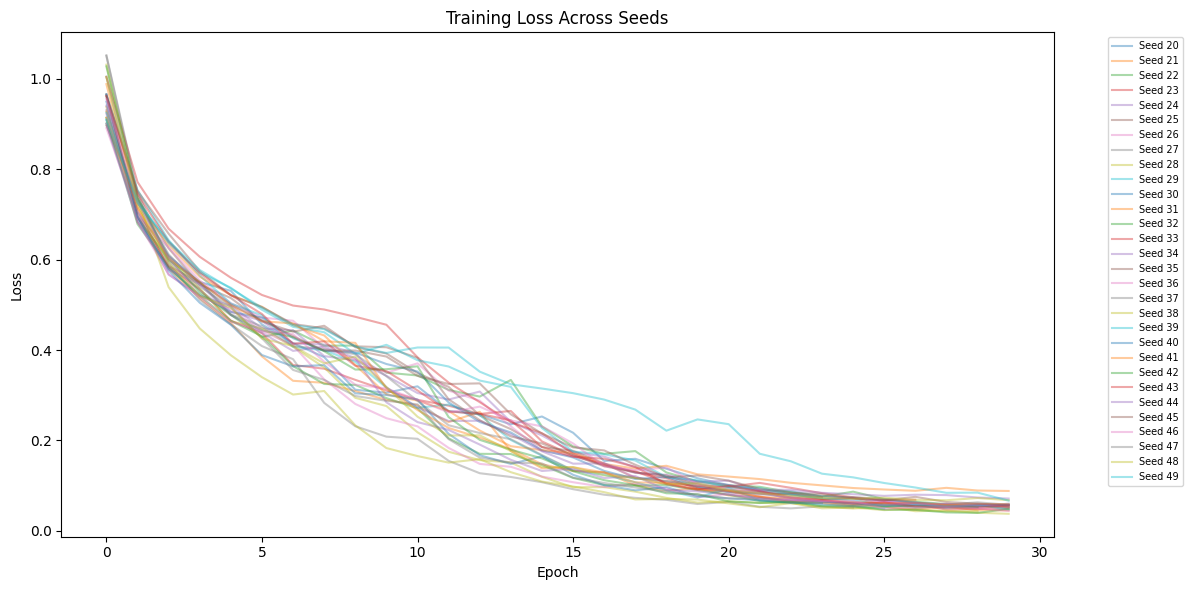

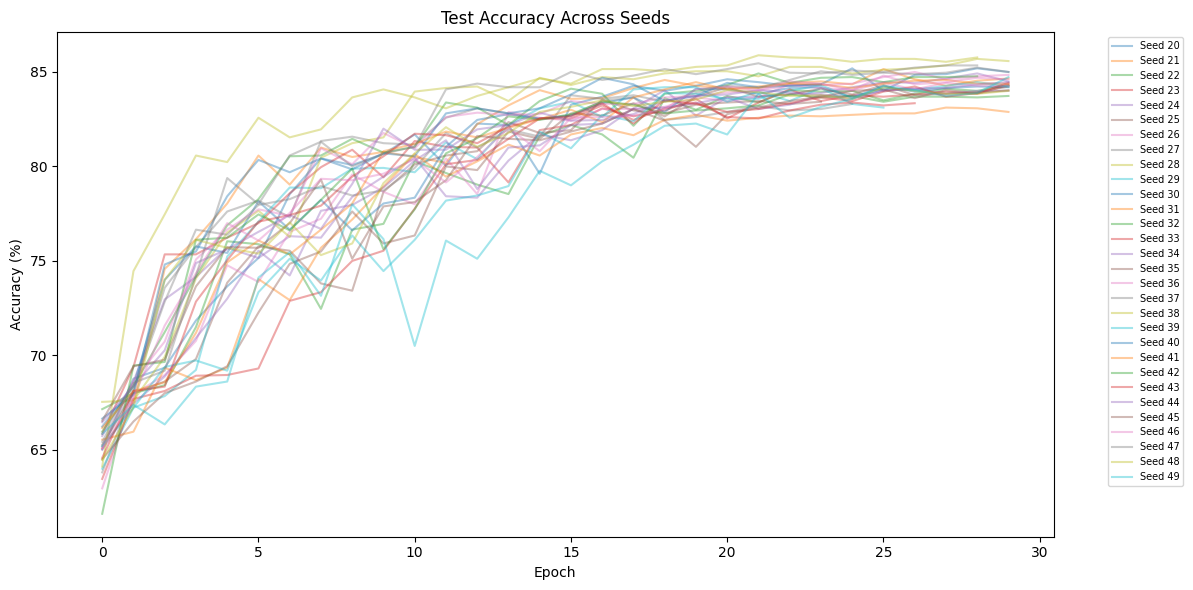

In [15]:
# --- Plot Training Loss for all seeds ---
plt.figure(figsize=(12,6))
for seed, losses in all_train_losses.items():
    plt.plot(losses, alpha=0.4, label=f"Seed {seed}")
plt.title("Training Loss Across Seeds")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=7)
plt.tight_layout()
plt.show()

# --- Plot Test Accuracy for all seeds ---
plt.figure(figsize=(12,6))
for seed, acc in all_test_acc.items():
    plt.plot(acc, alpha=0.4, label=f"Seed {seed}")
plt.title("Test Accuracy Across Seeds")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=7)
plt.tight_layout()
plt.show()


In [ ]:
import pickle
import os
import ipynbname

# Get current notebook name
try:
    # Get notebook name (without .ipynb extension)
    notebook_name = ipynbname.name()

except:
    notebook_name = "Notebook"  # fallback if can't get notebook name

# Create folder with notebook name if it doesn't exist
if not os.path.exists(notebook_name):
    os.makedirs(notebook_name)

# Path to save
save_path = os.path.join(notebook_name, "all_results.pkl")

# Save results
results = {
    "train_losses": all_train_losses,
    "test_losses": all_test_losses,
    "train_acc": all_train_acc,
    "test_acc": all_test_acc,
    "best_seed": best_seed,
    "best_acc": best_acc_overall,
}

with open(save_path, "wb") as f:
    pickle.dump(results, f)

torch.save(best_model_state, os.path.join(notebook_name, f"best_model{best_seed}.pth"))

print(f" Saved all training histories to {save_path}")


 Saved all training histories to main_1_ffnn_cg50_leg_singlelead/all_results.pkl


In [17]:
# === Instantiate a new model object ===
model = Model().to(device)

# === Load the best saved state dict ===
model.load_state_dict(best_model_state)

# === Set to evaluation mode ===
model.eval()

print(f"Loaded best model from seed {best_seed} with accuracy {best_acc_overall:.2f}")


Loaded best model from seed 38 with accuracy 85.88


you are back to the default directory: /home/karansingh/Documents/summer term/ECG_ML/MAIN


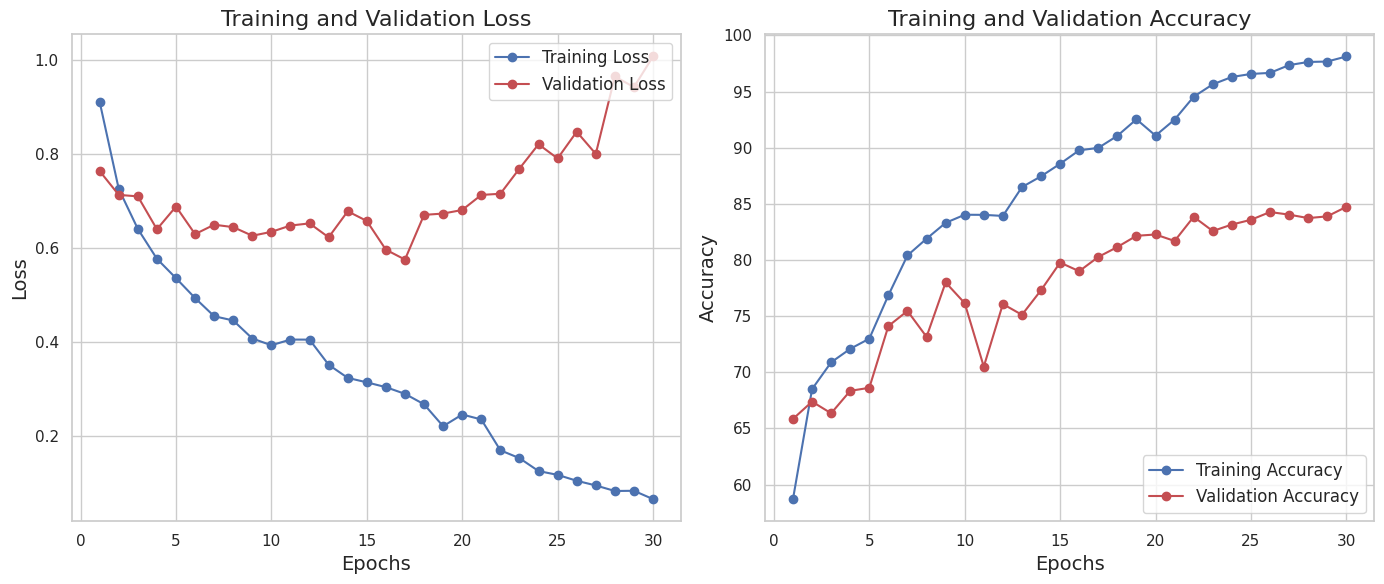

In [18]:
default_directory()
from plots import accuracy_and_validation_plots


# Example data: Replace these with your actual training and validation data
epochs_= list(range(1, len(train_losses_list)+1))

accuracy_and_validation_plots(epochs_, train_losses_list, test_losses_list, accuracy_train_list,accuracy_test_list).plot_figure("accuracy.png")


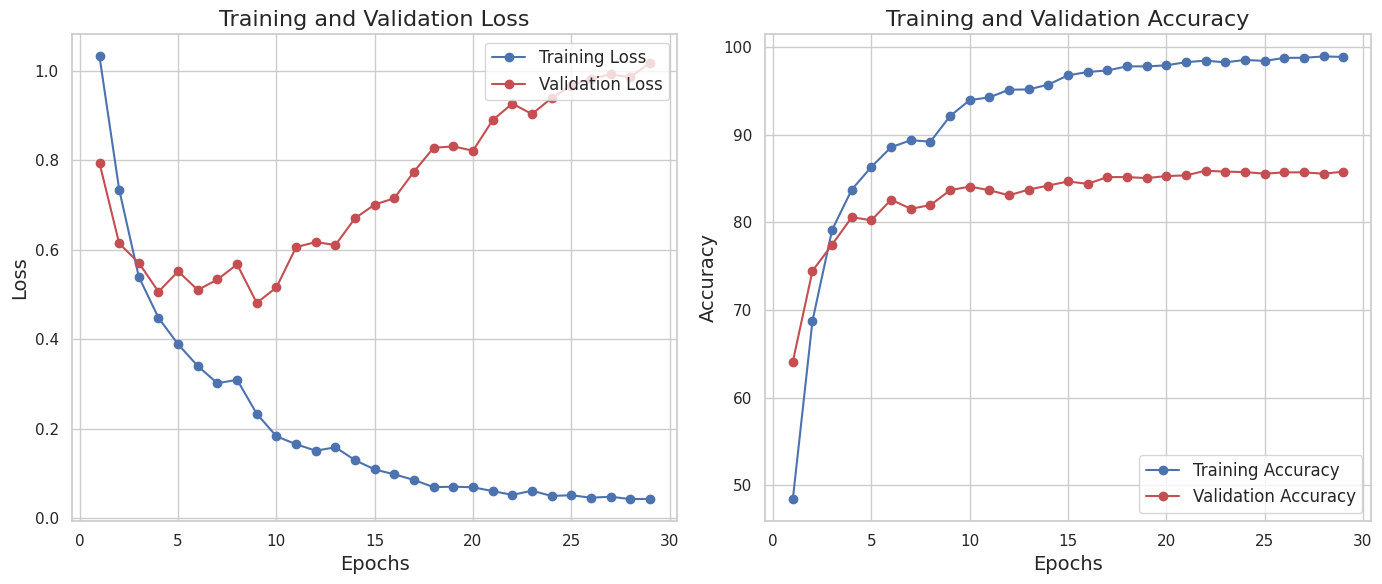

In [19]:

from plots import accuracy_and_validation_plots
epochs_= list(range(1, len(all_train_losses[best_seed])+1))
accuracy_and_validation_plots(epochs_,
    all_train_losses[best_seed],
    all_test_losses[best_seed],
    all_train_acc[best_seed],
    all_test_acc[best_seed]
).plot_figure("accuracy.png")


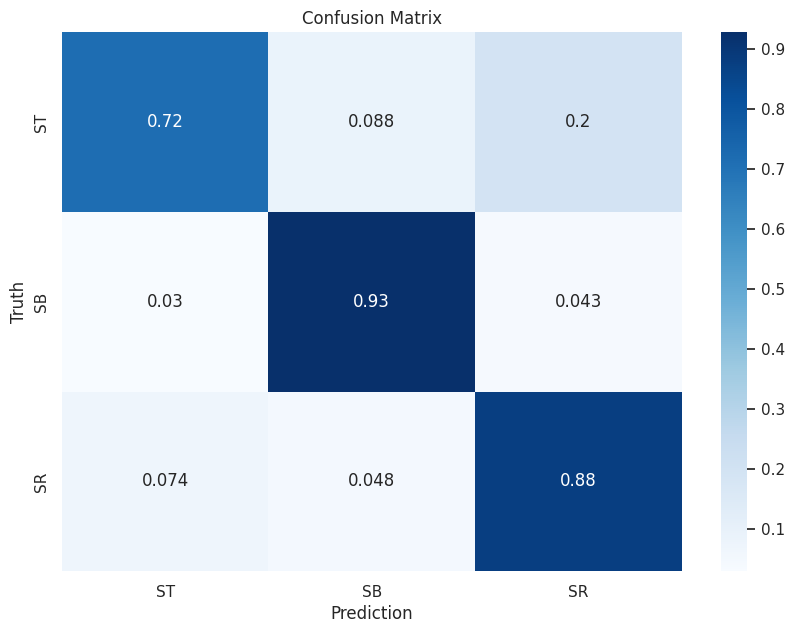

In [20]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import torch.nn.functional as F

model.eval()
y_pred = []
y_true = []
y_scores = []  # Added to collect probability scores

with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model(images.to(device))
        # Get probability scores using softmax
        probabilities = F.softmax(outputs, dim=1)
        y_scores.extend(probabilities.cpu().numpy())
        
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Convert to numpy arrays
y_scores = np.array(y_scores)

cm = confusion_matrix(y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix
df_cm = pd.DataFrame(cm, index=["ST", "SB", "SR"], columns=["ST", "SB", "SR"])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

In [21]:

#Classification Report for Test Data:

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["ST", "SB", "SR"]))


              precision    recall  f1-score   support

          ST       0.81      0.72      0.76       614
          SB       0.90      0.93      0.91      1015
          SR       0.84      0.88      0.86       971

    accuracy                           0.86      2600
   macro avg       0.85      0.84      0.84      2600
weighted avg       0.86      0.86      0.86      2600



Average precision score, micro-averaged over all classes: 0.93


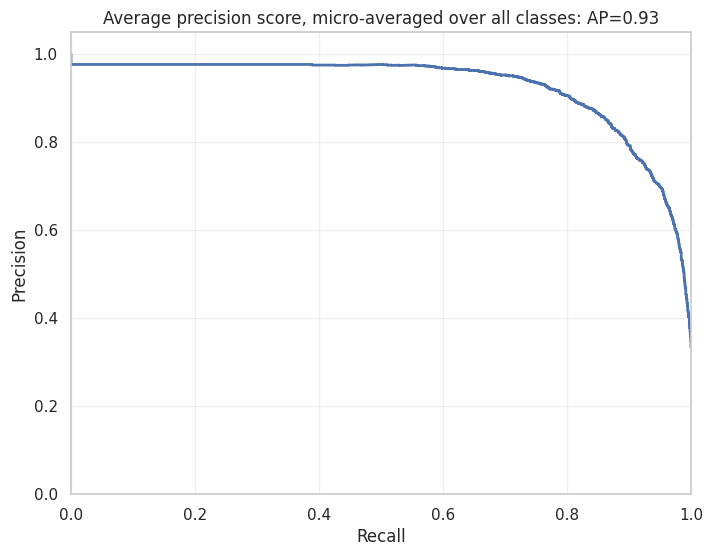

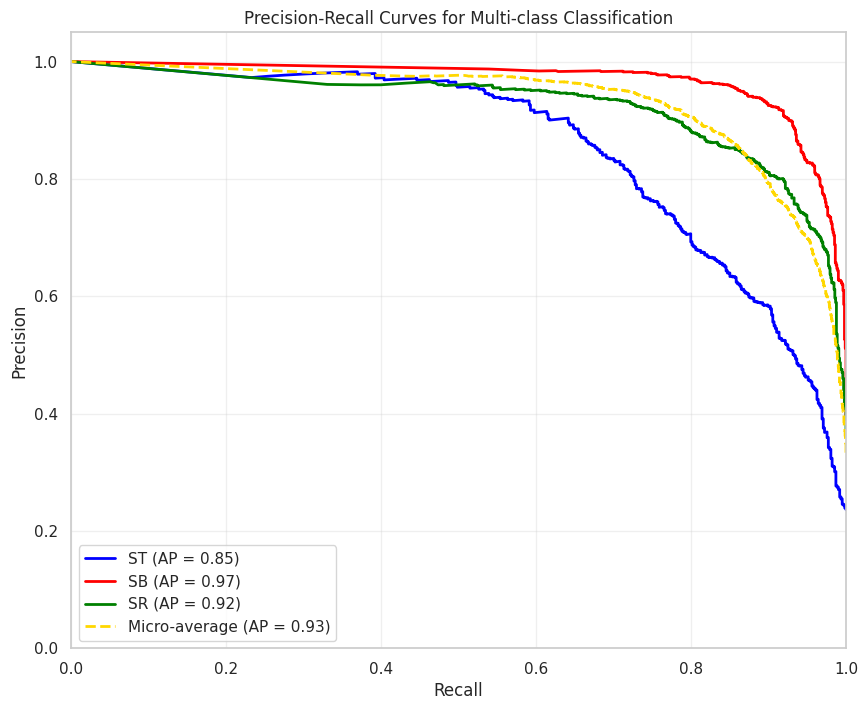

In [22]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()

# For each class, compute PR curve using probability scores
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(
        (np.array(y_true) == i).astype(int),  # Binary true labels for class i
        y_scores[:, i]  # Probability scores for class i
    )
    average_precision[i] = average_precision_score(
        (np.array(y_true) == i).astype(int), 
        y_scores[:, i]
    )

# Micro-average: using probability scores
from sklearn.preprocessing import label_binarize
y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_true_binary.ravel(),
    y_scores.ravel()
)
average_precision["micro"] = average_precision_score(
    y_true_binary, 
    y_scores,
    average="micro"
)

print('Average precision score, micro-averaged over all classes: {0:0.2f}'
        .format(average_precision["micro"]))

# Plot micro-average PR curve
plt.figure(figsize=(8, 6))
plt.step(recall['micro'], precision['micro'], where='post', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
plt.grid(True, alpha=0.3)
plt.show()

# Plot individual class PR curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
class_names = ['ST', 'SB', 'SR']

for i, color, class_name in zip(range(3), colors, class_names):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'{class_name} (AP = {average_precision[i]:0.2f})')

plt.plot(recall['micro'], precision['micro'], color='gold', lw=2, linestyle='--',
         label=f'Micro-average (AP = {average_precision["micro"]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curves for Multi-class Classification')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

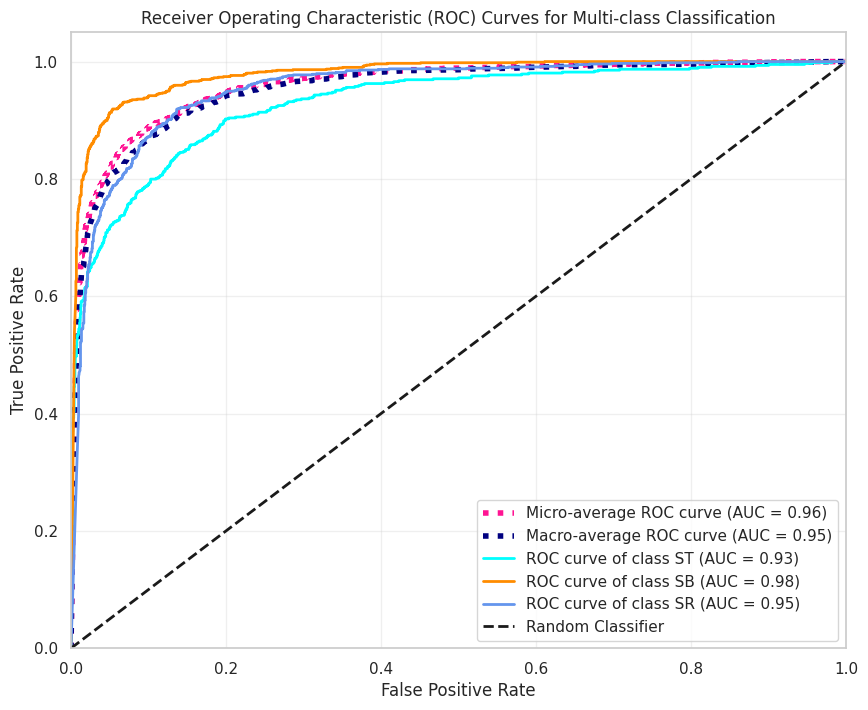

AUC Scores:
Class ST: 0.930
Class SB: 0.978
Class SR: 0.953
Micro-average: 0.959
Macro-average: 0.954


In [23]:
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the true labels for multi-class ROC
y_test = label_binarize(y_true, classes=[0, 1, 2])
# Use probability scores (not predictions!)
y_score = y_scores  # This contains the probability scores from softmax

n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue']
class_names = ['ST', 'SB', 'SR']

for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_name} (AUC = {roc_auc[i]:0.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multi-class Classification')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Print AUC scores
print("AUC Scores:")
for i, class_name in enumerate(['ST', 'SB', 'SR']):
    print(f"Class {class_name}: {roc_auc[i]:.3f}")
print(f"Micro-average: {roc_auc['micro']:.3f}")
print(f"Macro-average: {roc_auc['macro']:.3f}")